In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
import os,glob
import cv2 as cv

# 读取数据并将之转换为灰度图

dtype('uint8')

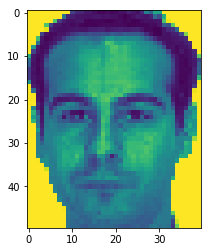

In [2]:
picture_path = "/media/tht/OS/2018机器学习/机器学习课程实验材料/AR/AR/"
Image = cv.imread(picture_path+"001-01.bmp",cv.IMREAD_GRAYSCALE) # 转换为灰度图
pyplot.imshow(Image)
Image.shape
Image.dtype

In [3]:
Image_list = []
for name in glob.glob(picture_path+"*-01.bmp"):
    Image = cv.imread(name,cv.IMREAD_GRAYSCALE) # 转换为灰度图
#     print(Image.dtype)
    image = Image.copy().reshape(1,2000) # 将图像压缩成一个1*2000的张量
#     print(image.dtype)
    Image_list.append(image)
    
len(Image_list)

120

In [4]:
Image_mat = np.vstack((Image_list)) # 所有图像连接成为一个矩阵
Image_mat[0]

array([254, 254, 254, ..., 254, 254, 254], dtype=uint8)

# 将每一张图片进行零均值化
$$
\mu = {1\over n}\sum_{i=1}^{n}x_i
$$
$$
Z = X-\mu
$$

In [5]:
u = np.mean(Image_mat,axis =0)
Z = Image_mat - u
Z.shape
u.dtype

dtype('float64')

# 求斜方差矩阵
$$
S = {1 \over m}ZZ^T
$$ 

In [6]:
S = np.cov(Z,rowvar=0)
S.shape

(2000, 2000)

# 求斜方差矩阵的特征值和特征向量

In [7]:
eig_val,eig_vector = np.linalg.eig(S)
print(eig_val.shape)
print(eig_vector.shape)

(2000,)
(2000, 2000)


# 对特征值进行排序

In [8]:
sorted_eig_val = np.argsort(eig_val)[-1::-1]
sorted_eig_val.shape

(2000,)

# 提取前K大个特征值的特征向量
**percentage为超参数可以自己调节**

我们根据特征值矩阵的百分比来计算最大的K个特征值(重建差异值，重构误差)

In [9]:
def percentage2n(eig_val,percentage):
    sortArray = np.sort(eig_val)
    sortArray = sortArray[-1::-1]
    Array_sum = sum(sortArray)
    temp = 0
    num =0
    for i in sortArray:
        temp+=i
        num+=1
        if temp>=Array_sum*percentage:
            return num

In [10]:
k = percentage2n(eig_val,0.8)
K_eig_vector = eig_vector[:,sorted_eig_val[0:k]]
K_eig_vector.shape

(2000, 19)

/home/tht/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


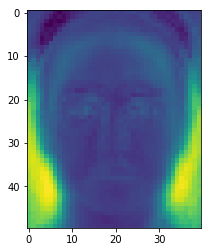

In [11]:
pyplot.imshow((K_eig_vector.T)[0].reshape(50,40).astype("float64"))

# 得到降为K维后的数据

**(W为上面k维特征值所组成的矩阵)**

$$
D = ZW
$$

$$
Y = DW^T+\mu
$$

In [12]:
D = Z.dot(K_eig_vector)
Y = D.dot(K_eig_vector.T) + u

dtype('uint8')

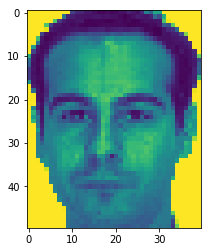

In [13]:
pyplot.imshow(Image_mat[0].reshape(50,40))
Image_mat[0].dtype

/home/tht/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


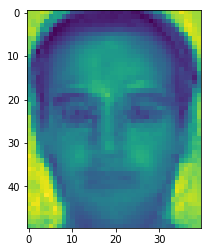

In [14]:
pyplot.imshow(Y[0,:].astype('float64').reshape(50,40))

# 计算重建误差

In [15]:
def get_deviation(pre,after):
    return np.sum((after - pre)**2) / np.sum(pre**2)

In [16]:
print(get_deviation(Image_mat[0].astype('float64'),Y[0,:].astype('float64')))

0.029005798397494738


/home/tht/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


# 最近临法判别身份，评估识别准确率

In [17]:
def get_distance(train,test):
    '''
    计算欧氏距离相似度
    :param train: 二维训练集
    :param test: 一维测试集
    :return: 该测试集到每一个训练集的欧氏距离
    '''
    return [np.linalg.norm(i - test) for i in train]

In [18]:
def get_PCA(test_image,u,K_eig_vector):
    test_image_Z = test_image-u
    test_image_D = test_image_Z.dot(K_eig_vector)
    test_image_Y = test_image_D.dot(K_eig_vector.T) + u
    return test_image_Y

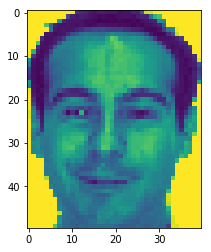

In [19]:
Image = cv.imread(picture_path+"001-02.bmp",cv.IMREAD_GRAYSCALE) # 转换为灰度图
pyplot.imshow(Image)
test_image = get_PCA(Image.copy().reshape(1,2000).astype("float64"),u,K_eig_vector)
distance = get_distance(Image_mat,test_image)

In [20]:
min_tag = distance.index(min(distance))
print(min_tag)

0


In [32]:
right_size = 0
for name in glob.glob(picture_path+"*-02.bmp"):
    Image = cv.imread(name,cv.IMREAD_GRAYSCALE) # 转换为灰度图
    test_image = get_PCA(Image.copy().reshape(1,2000).astype("float64"),u,K_eig_vector)
    distance = get_distance(Image_mat,test_image)
    min_tag = distance.index(min(distance))
    if min_tag+1 == int(name[len(picture_path):len(picture_path)+3]):
        right_size+=1

print(right_size / len(distance))

0.9583333333333334


# 使用Sklearn中的PCA降维方法进行对比
参数说明：
+ n_components: PCA算法中所要保留的主成分个数n，缺省时默认为None，所有成分被保留。若赋值为int，比如n_components=1，将把原始数据降到一个维度。赋值为小数，比如n_components = 0.9，将自动选取特征个数n，使得满足所要求的方差百分比。
+ copy: 类型：bool，True或者False，缺省时默认为True。表示是否在运行算法时，将原始训练数据复制一份,若为True，则运行PCA算法后，原始训练数据的值不会有任何改变，因为是在原始数据的副本上进行运算；若为False，则运行PCA算法后，原始训练数据的值会改，因为是在原始数据上进行降维计算。
+ whiten:类型：bool，缺省时默认为False。意义：白化，使得每个特征具有零均值、单位方差

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA(0.8)
pca.fit(Image_mat)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [24]:
res = pca.fit_transform(Image_mat)

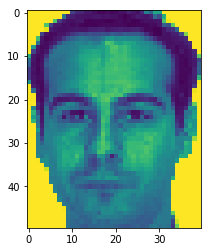

In [25]:
pyplot.imshow(Image_mat[0].reshape(50,40))

In [26]:
Ureduce = pca.components_ 
x_rec = np.dot(res,Ureduce)
Ureduce.shape

(19, 2000)

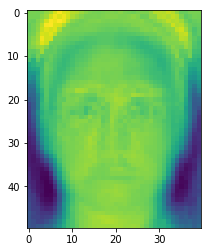

In [27]:
pyplot.imshow(Ureduce[0].reshape(50,40))

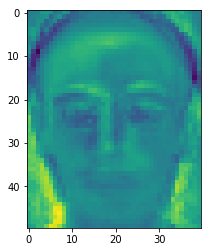

In [28]:
pyplot.imshow(x_rec[0].reshape(50,40))